# Ноутбук 01: Data Exploration (EDA)

**Цели:**

- Изучить датасет;
 
- Понять его структуру, качество данных;
 
- Сделать выводы ради понимания особенностей для будущего моделирования.

In [15]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

## Загрузка данных

Читаем CSV файл с белковыми последовательностями и их вторичными структурами.


In [37]:
cleaned_df_file = "../data/raw/2022-08-03-ss.cleaned.csv"
df = pd.read_csv(cleaned_df_file)
display(df.head(5))

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa
0,1A30,C,EDL,CBC,CEC,3,False
1,1B05,B,KCK,CBC,CEC,3,False
2,1B0H,B,KAK,CBC,CEC,3,False
3,1B1H,B,KFK,CBC,CEC,3,False
4,1B2H,B,KAK,CBC,CEC,3,False


## Базовая информация о датасете

Проверяем размер датасета, типы данных и структуру колонок.


In [22]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477153 entries, 0 to 477152
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   pdb_id         477153 non-null  object 
 1   chain_code     477153 non-null  object 
 2   seq            477153 non-null  object 
 3   sst8           477153 non-null  object 
 4   sst3           477153 non-null  object 
 5   len            477153 non-null  int64  
 6   has_nonstd_aa  477153 non-null  bool   
 7   H_frac         477153 non-null  float64
 8   E_frac         477153 non-null  float64
 9   C_frac         477153 non-null  float64
dtypes: bool(1), float64(3), int64(1), object(5)
memory usage: 33.2+ MB


pdb_id           0
chain_code       0
seq              0
sst8             0
sst3             0
len              0
has_nonstd_aa    0
H_frac           0
E_frac           0
C_frac           0
dtype: int64

##  Анализ длин последовательностей

Визуализируем распределение длин белковых последовательностей: гистограмма и boxplot.
Это нужно для выбора оптимального `max_length` для padding.


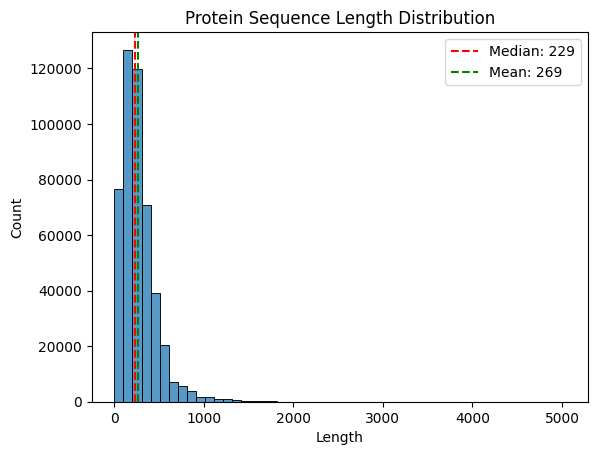

In [38]:
sns.histplot(df['len'], bins=50)
plt.title('Protein Sequence Length Distribution')
plt.xlabel('Length')

plt.axvline(df['len'].median(), color='red', linestyle='--', label=f'Median: {df["len"].median():.0f}')
plt.axvline(df['len'].mean(), color='green', linestyle='--', label=f'Mean: {df["len"].mean():.0f}')
plt.legend()

##  Распределение классов вторичной структуры (H, E, C)

Подсчитываем сколько раз встречается каждый класс структуры во всех белках.
Это нужно для выявления дисбаланса классов.



Распределение классов структур:
Класс      Количество      Процент   
----------------------------------------
H            43,559,646        33.96%
E            26,166,197        20.40%
C            58,525,533        45.63%
----------------------------------------
ВСЕГО       128,251,376       100.00%


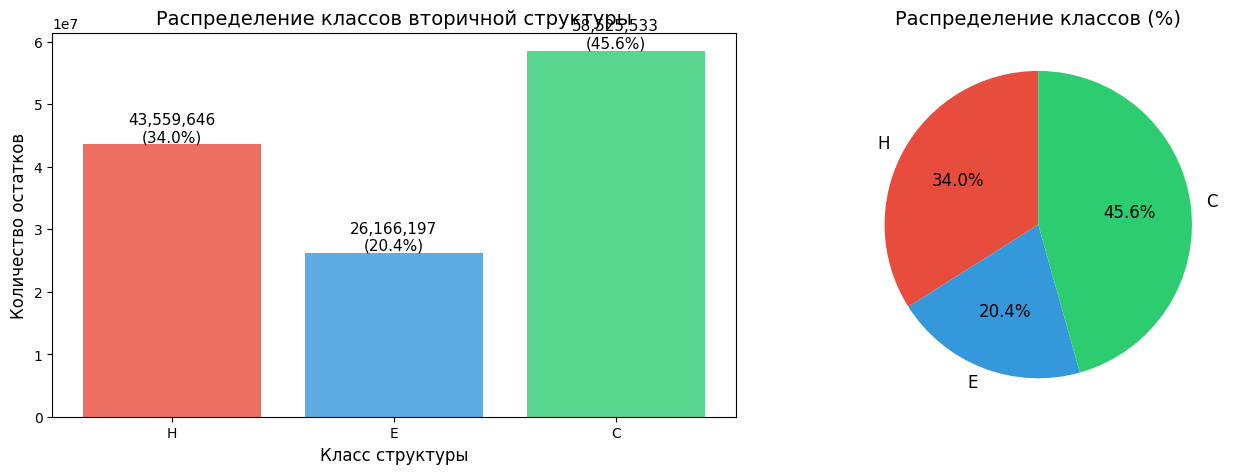

In [41]:
# Подсчёт каждого класса во всех последовательностях
def count_structure_classes(df, column='sst3'):
    total_counts = {'H': 0, 'E': 0, 'C': 0}
    
    for seq in df[column]:
        for char in seq:
            if char in total_counts:
                total_counts[char] += 1
    
    total = sum(total_counts.values())
    percentages = {k: (v/total)*100 for k, v in total_counts.items()}
    
    return total_counts, percentages

# Вызываем функцию
counts, percentages = count_structure_classes(df)
total = sum(counts.values())

# Выводим результаты
print(f"\nРаспределение классов структур:")
print(f"{'Класс':<10} {'Количество':<15} {'Процент':<10}")
print("-" * 40)
for cls in ['H', 'E', 'C']:
    print(f"{cls:<10} {counts[cls]:>12,} {percentages[cls]:>12.2f}%")
print("-" * 40)
print(f"{'ВСЕГО':<10} {total:>12,} {100.00:>12.2f}%")

# Визуализация распределения классов
plt.figure(figsize=(14, 5))

# Bar chart с процентами
plt.subplot(1, 2, 1)
bars = plt.bar(counts.keys(), counts.values(), color=['#e74c3c', '#3498db', '#2ecc71'], alpha=0.8)
plt.xlabel('Класс структуры', fontsize=12)
plt.ylabel('Количество остатков', fontsize=12)
plt.title('Распределение классов вторичной структуры', fontsize=14)

# Добавляем текст с процентами на барах
for bar, cls in zip(bars, counts.keys()):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{counts[cls]:,}\n({percentages[cls]:.1f}%)',
             ha='center', va='bottom', fontsize=11)

# Pie chart
plt.subplot(1, 2, 2)
colors = ['#e74c3c', '#3498db', '#2ecc71']
plt.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%', 
        colors=colors, startangle=90, textprops={'fontsize': 12})
plt.title('Распределение классов (%)', fontsize=14)

plt.tight_layout()
plt.show()

## Композиция структур внутри каждого белка

Анализируем как распределены H/E/C внутри каждого белка (а не по всему датасету).

Text(0.5, 1.0, 'H/E/C Composition Per Sequence')

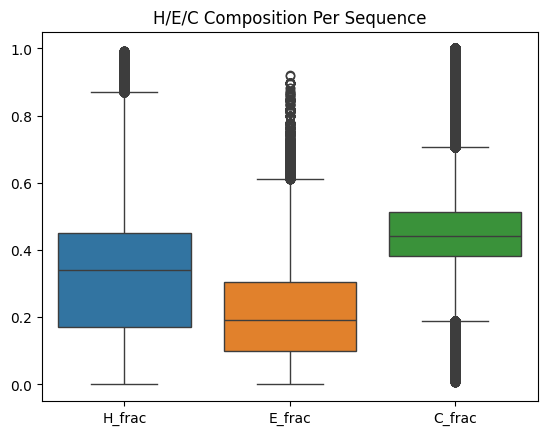

In [42]:
df['H_frac'] = df['sst3'].apply(lambda s: s.count('H') / len(s))
df['E_frac'] = df['sst3'].apply(lambda s: s.count('E') / len(s))
df['C_frac'] = df['sst3'].apply(lambda s: s.count('C') / len(s))

sns.boxplot(data=df[['H_frac', 'E_frac', 'C_frac']])
plt.title('H/E/C Composition Per Sequence')

##  Ещё необходимая информация о датасете и проверки на корректность данных

In [43]:
print(f"Total valid sequences: {len(df)}")

Total valid sequences: 477153


In [18]:
residues = set(''.join(df['seq']))
print('Unique residues:', sorted(residues))

Unique residues: ['*', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


In [23]:
# Проверяем что длины seq, sst3, sst8 совпадают
df['seq_len'] = df['seq'].str.len()
df['sst3_len'] = df['sst3'].str.len()
df['sst8_len'] = df['sst8'].str.len()

print("Длины совпадают (seq == sst3):", (df['seq_len'] == df['sst3_len']).all())
print("Длины совпадают (seq == sst8):", (df['seq_len'] == df['sst8_len']).all())


Длины совпадают (seq == sst3): True
Длины совпадают (seq == sst8): True


In [44]:
# Определяем оптимальный max_length
percentiles = [50, 75, 90, 95, 99]
print("\nПерцентили длин последовательностей:")
for p in percentiles:
    value = df['len'].quantile(p/100)
    coverage = (df['len'] <= value).sum() / len(df) * 100
    print(f"{p}%: {value:.0f} аминокислот (покрывает {coverage:.1f}% данных)")

# Рекомендация
max_len_512 = (df['len'] <= 512).sum() / len(df) * 100
max_len_700 = (df['len'] <= 700).sum() / len(df) * 100
print(f"\nРекомендация:")
print(f"- max_length=512 покрывает {max_len_512:.1f}% данных")
print(f"- max_length=700 покрывает {max_len_700:.1f}% данных")


Перцентили длин последовательностей:
50%: 229 аминокислот (покрывает 50.2% данных)
75%: 345 аминокислот (покрывает 75.1% данных)
90%: 496 аминокислот (покрывает 90.0% данных)
95%: 606 аминокислот (покрывает 95.0% данных)
99%: 1031 аминокислот (покрывает 99.0% данных)

Рекомендация:
- max_length=512 покрывает 91.1% данных
- max_length=700 покрывает 96.5% данных


# 📊 Основные выводы по датасету

### 1. Размер датасета
- **Количество белков:** 40,716
- **Диапазон длин:** от 3 до 1000+ аминокислот

### 2. Распределение длин последовательностей
- **Медиана:** ~229 аминокислот
- **Среднее:** ~269 аминокислот
- **95-й перцентиль:** ~606 аминокислот
- **Рекомендация:** использовать `max_length=700` для padding (покрывает 96.5% данных)

### 3. Распределение классов структур (H, E, C)
- **H (Helix):** 33.96% — среднее распространение
- **E (Sheet):** 20.40% — ниже среднего  
- **C (Coil):** 45.63% — наиболее частый класс
- **Вывод:** Есть существенный дисбаланс классов. Значит стоит использовать `weighted loss` при обучении

### 4. Качество данных
- ✅ Пропущенных значений: 0
- ✅ Длины seq == sst3 == sst8: Совпадают для всех белков
- ✅ Данные готовы к preprocessing

### 5. Рекомендации для preprocessing
1. **Padding:** `max_length=700`
2. **Weighted Loss:** Да
3. **Train/Val/Test split:** 80/10/10
4. **Encoding:** One-hot или embedding для 20 аминокислот + padding token
